## Tracking sulfide saturation during magma evolution
- This Jupyter Notebook shows how to use the various functionalities of PySCSS to track sulfide saturation during magma evolution
- It uses data from Wieser et al. (in prep) looking at sulfide saturation during evolution from a basalt to a dacite at Kilauea Volcano
- We have measured sulfide compositions using EDS on the SEM in various matrix glasses to give as an idea of how sulfide composition is changing with differentation. This allows us to compare this to sulfide composition predicted by different models
- We have also made a best fit liquid line of descent, using a MELTS model, with some linear fitting to measured data at lower MgO contents where MELTS begins to go wrong (i.e. missing apatite saturation)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySCSS as ss
import Thermobar as pt
pd.options.display.max_columns = None

## 1. Load sulfide data

In [2]:
Sulfide_in=pd.read_excel('Sulfide_compositions.xlsx', sheet_name='Sheet1')

## 2. Load best fit liquid line of descent - Here I'm going to load it in Thermobar format, so I can use liquid-only thermometers

In [3]:
Liq_input=pt.import_excel('Dataset_S1.xlsx', sheet_name='Synthetic_Model_visc_traj', suffix="_Liq")
Liqs=Liq_input['Liqs']

In [4]:
# Im also loading in the matrix glass compositions and melt inclusions
MG=pd.read_excel('Dataset_S1.xlsx', sheet_name='Matrix_Glass_Data')
# Replace all floats with Nans
MG=MG.apply(pd.to_numeric, errors='coerce')

Plag_MIs=pd.read_excel('Dataset_S1.xlsx', sheet_name='Plagioclase_Hosted_MeltInc').apply(pd.to_numeric, errors='coerce')
Cpx_MIs=pd.read_excel('Dataset_S1.xlsx', sheet_name='Clinopyroxene_Hosted_MeltInc').apply(pd.to_numeric, errors='coerce')
Opx_MIs=pd.read_excel('Dataset_S1.xlsx', sheet_name='Orthopyroxene_hosted_MeltInc').apply(pd.to_numeric, errors='coerce')
Ol_MIs=pd.read_excel('Dataset_S1.xlsx', sheet_name='Olivine_Hosted_MeltInc').apply(pd.to_numeric, errors='coerce')


In [5]:

MI_Combo=pd.concat([Plag_MIs, Cpx_MIs, Opx_MIs, Ol_MIs], axis=0)


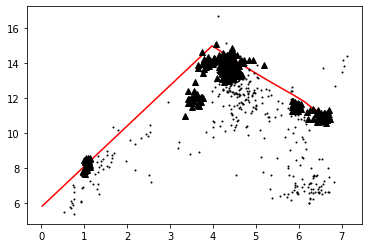

In [6]:
plt.plot(Liqs['MgO_Liq'], Liqs['FeOt_Liq'], '-r')
plt.plot(MG['MgO EPMA'], MG['FeO EPMA'], '^k')
plt.plot(MI_Combo['MgO_MI EPMA'], MI_Combo['FeO_MI EPMA'], 'ok', ms=1, mfc='white')

## 3. Calculate temperature 
- here I use Helz and Thornber, 1987, but lots of options exist in Thermobar

In [7]:
Liqs['temp_HT87']=pt.calculate_liq_only_temp(liq_comps=Liqs, equationT="T_Helz1987_MgO")


## 4. Calculate a regression strategy for Ni and Cu in the liquid
- If we want to predict the sulfide composition using Smythe or ONeill, we need the Ni and Cu contents in the liquid as a function of MgO

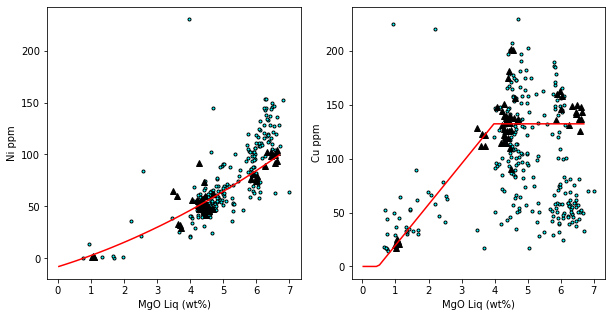

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(MI_Combo['MgO_MI EPMA'], MI_Combo['Ni_ppm_m60 LAICPMS'], 'ok', ms=3, mfc='cyan')

ax1.plot(MG['MgO EPMA'], MG['Ni_ppm_m60 LAICPMS'], '^k')
ax1.set_xlabel('MgO Liq (wt%)')
ax1.set_ylabel('Ni ppm')

# Polyfitting for Ni
mask_Ni= ~np.isnan(MG['MgO EPMA']) & ~np.isnan(MG['Ni_ppm_m60 LAICPMS'])
Pf_Ni = np.poly1d(np.polyfit(MG['MgO EPMA'].loc[mask_Ni], MG['Ni_ppm_m60 LAICPMS'].loc[mask_Ni], 2))
Px_Ni =Liqs['MgO_Liq']
Py_Ni = Pf_Ni(Px_Ni)

Liqs['Ni_modelled']=Py_Ni
ax1.plot(Liqs['MgO_Liq'], Liqs['Ni_modelled'], '-r')

ax2.plot(MI_Combo['MgO_MI EPMA'], MI_Combo['Cu_ppm_m65 LAICPMS'], 'ok', ms=3, mfc='cyan')
ax2.plot(MG['MgO EPMA'], MG['Cu_ppm_m65 LAICPMS'], '^k')
ax2.set_xlabel('MgO Liq (wt%)')
ax2.set_ylabel('Cu ppm')


# Polyfitting for Cu
mask_Cu= ~np.isnan(MG['MgO EPMA']) & ~np.isnan(MG['Cu_ppm_m65 LAICPMS']) & (MG['MgO EPMA']<4)
Pf_Cu = np.poly1d(np.polyfit(MG['MgO EPMA'].loc[mask_Cu], MG['Cu_ppm_m65 LAICPMS'].loc[mask_Cu], 1))


mask_low_MgO=Liqs['MgO_Liq']<4
Px_Cu =Liqs['MgO_Liq'].loc[mask_low_MgO]
Py_Cu = Pf_Cu(Px_Cu)

Liqs['Cu_modelled']=np.max(Py_Cu)
# Replacing any with <4 wt% MgO with the regression
Liqs.loc[(mask_low_MgO), 'Cu_modelled']=Py_Cu
# Replacing any negative values with zero
Liqs.loc[Liqs['Cu_modelled']<0, 'Cu_modelled']=0
ax2.plot(Liqs['MgO_Liq'], Liqs['Cu_modelled'], '-r')


## Finally, lets use the MELTS model used to reconstruct the first part of the line to calculate how Fe3Fet_Liq is changing 

C:\Users\penny\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3251: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


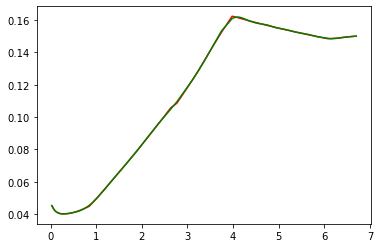

In [23]:
MELTS=pd.read_excel('Dataset_S1.xlsx', sheet_name='MELTS_Model_01H2O')
Fe3Fet_Liq=MELTS['Fe2O3']*0.8998/(MELTS['Fe2O3']*0.8998+MELTS['FeO'])
plt.plot(MELTS['MgO'], Fe3Fet_Liq, '-r')


Pf_MELTS = np.poly1d(np.polyfit(MELTS['MgO'], Fe3Fet_Liq, 100))
Px_MELTS =Liqs['MgO_Liq']
Py_MELTS = Pf_MELTS(Px_MELTS)
plt.plot(Liqs['MgO_Liq'], Py_MELTS, '-g')
Liqs['Fe3Fet_Liq']=Py_MELTS

In [ ]:
MELTS['Factor'

## Running Smythe model using predicted sulfide composition

In [10]:
Smythe_CalcSulf=ss.calculate_Smythe2017_SCSS(df=Liqs, T_K=Liqs['temp_HT87'], 
P_kbar=0.6, Fe_FeNiCu_Sulf="Calc_Smythe",
Fe3Fet_Liq=Liqs['Fe3Fet_Liq'], Ni_Liq=Liqs['Ni_modelled'], Cu_Liq=Liqs['Cu_modelled'])

In [11]:
ONeill_CalcSulf=ss.calculate_ONeill2021_SCSS(df=Liqs, T_K=Liqs['temp_HT87'], P_kbar=0.6, 
                                        Fe_FeNiCu_Sulf="Calc_ONeill",
                           Ni_Liq=Liqs['Ni_modelled'], Cu_Liq=Liqs['Cu_modelled'], Fe3Fet_Liq=Liqs['Fe3Fet_Liq'])


ONeill_CalcSmythe_Sulf=ss.calculate_ONeill2021_SCSS(df=Liqs, T_K=Liqs['temp_HT87'], P_kbar=0.6, 
                                        Fe_FeNiCu_Sulf="Calc_Smythe",
                           Ni_Liq=Liqs['Ni_modelled'], Cu_Liq=Liqs['Cu_modelled'], Fe3Fet_Liq=Liqs['Fe3Fet_Liq'])

In [12]:
### First, lets see how good the predictions of sulfide composition are

Text(0, 0.5, 'Cu/(Cu + Fe + Ni)')

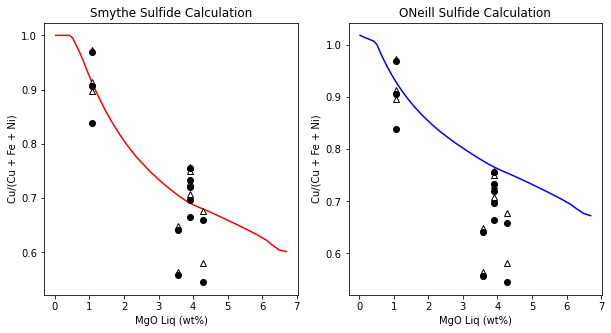

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Smythe Sulfide Calculation')
ax1.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['Fe_FeNiCu_Sulf_calc'], '-r')
ax1.plot(Sulfide_in['MgO Glass'], Sulfide_in['Fe/Fe+Ni+Cu Raw'], '^k', mfc='white')
ax1.plot(Sulfide_in['MgO Glass'], Sulfide_in['Fe/Fe+Ni+Cu Si Corr'], 'ok')

ax1.set_xlabel('MgO Liq (wt%)')
ax1.set_ylabel('Cu/(Cu + Fe + Ni)')


ax2.set_title('ONeill Sulfide Calculation')
ax2.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['Fe_FeNiCu_Sulf_calc'], '-b')
ax2.plot(Sulfide_in['MgO Glass'], Sulfide_in['Fe/Fe+Ni+Cu Raw'], '^k', mfc='white')
ax2.plot(Sulfide_in['MgO Glass'], Sulfide_in['Fe/Fe+Ni+Cu Si Corr'], 'ok')

ax2.set_xlabel('MgO Liq (wt%)')
ax2.set_ylabel('Cu/(Cu + Fe + Ni)')


## SCSS only accounting for S2- species

Text(0.5, 0, 'MgO (wt%)')

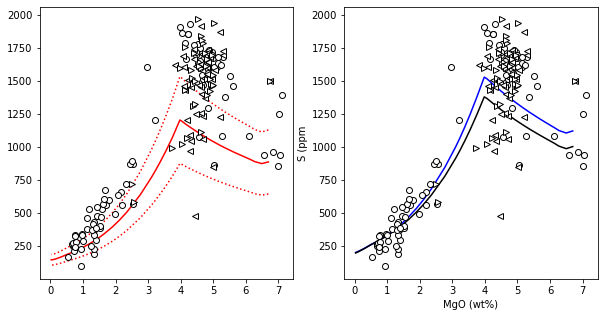

In [14]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10,5))


ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm'], '-b')
ax1.plot(ONeill_CalcSmythe_Sulf['MgO_Liq'], ONeill_CalcSmythe_Sulf['SCSS2_ppm'], '-k')
ax1.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax1.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax1.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017'], '-r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']+Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']-Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')

ax2.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax2.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax2.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax1.set_ylabel('S (ppm')
ax1.set_xlabel('MgO (wt%)')

## We can see that the models underestimate at 4-5 wt% MgO. 
- This could be becuase some S6+ is present. 
- We can use the Nash model to calculate the amount of S6+

In [15]:
s6St_Nash=ss.calculate_S6St_Nash2019(T_K=Liqs['temp_HT87'], Fe3Fet_Liq=Liqs['Fe3Fet_Liq'])
DeltaQFM=ss.convert_fe_partition_to_fo2(liq_comps=Liqs, T_K=Liqs['temp_HT87'], P_kbar=0.6).DeltaQFM

s6St_Jugo=ss.calculate_S6St_Jugo2010(DeltaQFM=DeltaQFM)

Text(0, 0.5, 'S$^{6+}$/S$_{T}$')

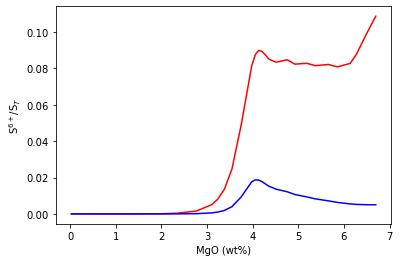

In [16]:
plt.plot(Liqs['MgO_Liq'], s6St_Nash, '-r')
plt.plot(Liqs['MgO_Liq'], s6St_Jugo, '-b')
plt.xlabel('MgO (wt%)')
plt.ylabel('S$^{6+}$/S$_{T}$')

Text(0.5, 0, 'Fe$^{3+}$/Fe$_{T}$')

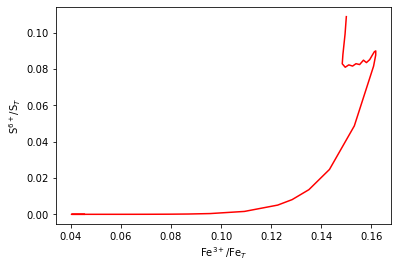

In [17]:
plt.plot(Liqs['Fe3Fet_Liq'], s6St_Nash, '-r')
plt.ylabel('S$^{6+}$/S$_{T}$')
plt.xlabel('Fe$^{3+}$/Fe$_{T}$')

Actual data for S and Fe redox from Allan Lerner PhD thesis SB8 par a)
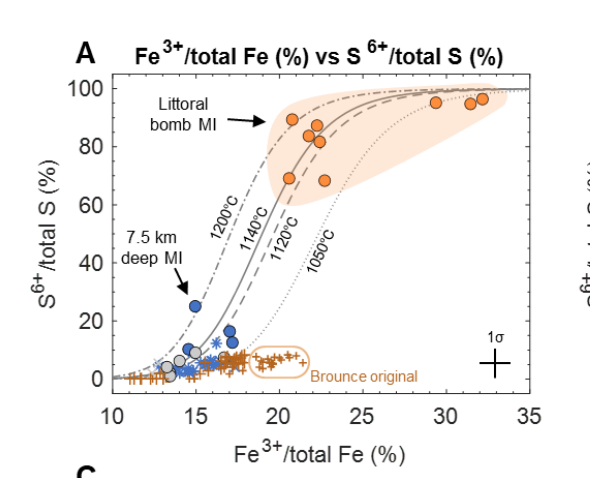

## Applying an S6+ correction using Nash

Text(0.5, 0, 'MgO (wt%)')

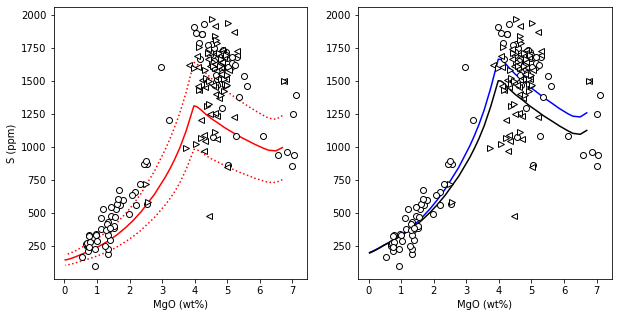

In [18]:
s6_corr_Nash=1/(1-s6St_Nash)
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10,5))


ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm']*s6_corr_Nash, '-b')
ax1.plot(ONeill_CalcSmythe_Sulf['MgO_Liq'], ONeill_CalcSmythe_Sulf['SCSS2_ppm']*s6_corr_Nash, '-k')
ax1.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax1.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax1.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash, '-r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash+Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash-Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')

ax2.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax2.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax2.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.set_ylabel('S (ppm)')
ax1.set_xlabel('MgO (wt%)')
ax2.set_xlabel('MgO (wt%)')

## Lets make a synthetic path with 20% S$^{6+}$, tailing off once Fe redox tanks

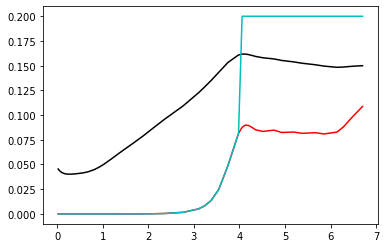

In [19]:
lowMgO=Liqs['MgO_Liq']<4
Liqs['S6ST']=0.2
Liqs.loc[lowMgO, 'S6ST']=s6St_Nash.loc[lowMgO]
    
plt.plot(Liqs['MgO_Liq'], Liqs['Fe3Fet_Liq'], '-k')
plt.plot(Liqs['MgO_Liq'], s6St_Nash, '-r')
plt.plot(Liqs['MgO_Liq'], Liqs['S6ST'], '-c')



## Applying a correction to 4 wt%, where redox tanks

Text(0.5, 0, 'MgO (wt%)')

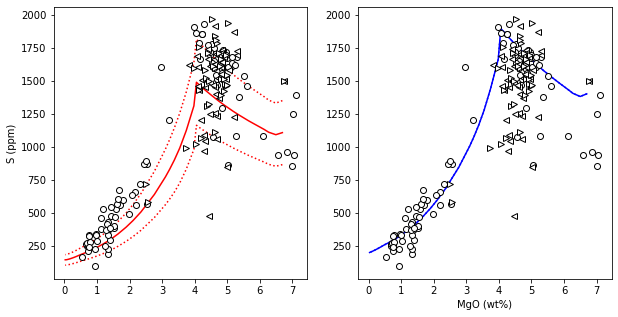

In [20]:
s6_corr_20=1/(1-0.2)
s6_corr_40=1/(1-Liqs['S6ST'])
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm']*s6_corr_40, ':b')

ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm']*s6_corr_40, '-b')

ax2.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_40, '-r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_40+Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_40-Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')

ax2.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax2.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax2.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')
ax1.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax1.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax1.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.set_ylabel('S (ppm)')
ax1.set_xlabel('MgO (wt%)')

ValueError: x and y must have same first dimension, but have shapes (17,) and (49,)

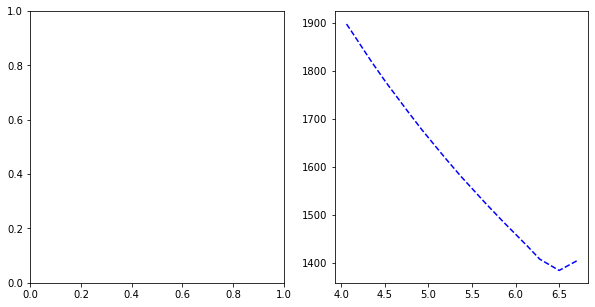

In [21]:
s6_corr_20=1/(1-0.2)
s6_corr_40=1/(1-Liqs['S6ST'])
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10,5))

high_MgO=ONeill_CalcSulf['MgO_Liq']>4
ax1.plot(ONeill_CalcSulf['MgO_Liq'].loc[high_MgO], ONeill_CalcSulf['SCSS2_ppm'].loc[high_MgO]*s6_corr_20, '--b')
ax1.plot(ONeill_CalcSulf['MgO_Liq'].loc[high_MgO], ONeill_CalcSulf['SCSS2_ppm'].loc[high_MgO]*s6_corr_40, ':b')

ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm']*s6_corr_Nash, '-b')
ax1.plot(ONeill_CalcSmythe_Sulf['MgO_Liq'], ONeill_CalcSmythe_Sulf['SCSS2_ppm']*s6_corr_Nash, '-k')
ax1.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax1.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax1.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.plot(Smythe_CalcSulf['MgO_Liq'], Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash, '-r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash+Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')
ax2.plot(Smythe_CalcSulf['MgO_Liq'], 
        Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017']*s6_corr_Nash-Smythe_CalcSulf['SCSS_ideal_ppm_Smythe2017_1sigma'], ':r')

ax2.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax2.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax2.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')

ax2.set_ylabel('S (ppm)')
ax1.set_xlabel('MgO (wt%)')

## Calculating amount of S precipitated. 
- Loading in "factor" which is basically tracking how much elements are increasing due to fractional crystallization

(0.0, 3000.0)

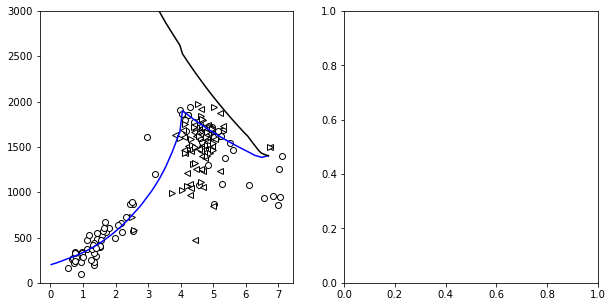

In [22]:
S_Incomp=1400*MELTS['Factor']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Plag_MIs['MgO_MI EPMA'], Plag_MIs['S_MI EPMA (ppm)'], 'ok', mfc='white')  
ax1.plot(Cpx_MIs['MgO_MI EPMA'], Cpx_MIs['S_MI EPMA (ppm)'], '<k', mfc='white') 
ax1.plot(Opx_MIs['MgO_MI EPMA'], Opx_MIs['S_MI EPMA (ppm)'], '>k', mfc='white')


ax1.plot(ONeill_CalcSulf['MgO_Liq'], ONeill_CalcSulf['SCSS2_ppm']*s6_corr_40, '-b')
ax1.plot(MELTS['MgO'], S_Incomp, '-k')

ax1.set_ylim([0, 3000])

## Amount of sulfide precipitated
- Can write as a mass balance.

S$_{Tot}$ = S$_{Melt}$* (2-X$_{sulf}$) + S$_{sulf}$*(X$_{sulf}$)

X$_{sulf}$ = (S$_{Tot}$  - S$_{Melt}$ )/(S$_{sulf}$ - S$_{Melt}$)

In [85]:
# Mean S in sulfide
S_sulf=np.mean(Sulfide_in['S'])*10000
S_sulf

283533.3333333334

In [86]:
X_sulf= (S_Incomp-ONeill_CalcSulf['SCSS2_ppm']*s6_corr_40)/(S_sulf-ONeill_CalcSulf['SCSS2_ppm']*s6_corr_40)

Text(0, 0.5, 'Sulf frac')

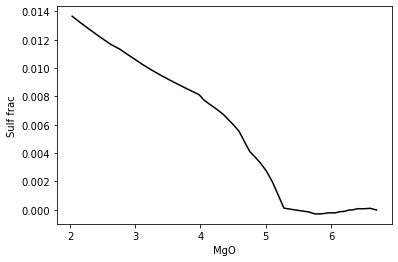

In [88]:
plt.plot(MELTS['MgO'], X_sulf, '-k')
plt.xlabel('MgO')
plt.ylabel('Sulf frac')

## This needs work, but this is just a quick proof of concept
- have asked emma if she is interested in this

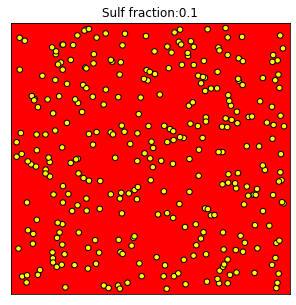

In [33]:
from matplotlib import patches
x_len_mm=1
y_len_mm=1
rect = patches.Rectangle((0,0),x_len_mm,y_len_mm,linewidth=1,edgecolor='r',facecolor='red', label='test')
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5), sharey=True)
# Add the patch to the Axes
ax1.add_patch(rect)

area_rect=x_len_mm*y_len_mm
Vol_frac=0.1
area_sulf=area_rect*Vol_frac
sulf_rad=10*10**(-3)
area_1sulf=np.pi*sulf_rad**2
number_sulf=area_sulf/area_1sulf
circ1=patches.Circle((0.5, 0.5), sulf_rad, edgecolor='k', facecolor='yellow')
ax1.add_patch(circ1)
for i in range(0, int(np.round(number_sulf))):
    circ=patches.Circle((np.random.uniform(0.02, 0.98), np.random.uniform(0.02, 0.98)),
                        sulf_rad, edgecolor='k', facecolor='yellow')
    ax1.add_patch(circ)
    
ax1.set_title('Sulf fraction:' + str(Vol_frac))

ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)

In [20]:
np.round(number_sulf)

32.0